# Implement DQN based on Atari Breakout game

## 1. Prepare the basic environment

In this part, we import the necessary lib for the project, which including gym related environment.

In [ ]:
# import
import os
from typing import Dict, List, Tuple
from collections import deque
import random
import cv2
import itertools

import gym
from gym import spaces
from pyvirtualdisplay import Display
from gym.spaces import Box
from gym.spaces.box import Box
from gym.core import ObservationWrapper
from gym.core import Wrapper

import pyglet
from pyglet import gl

import matplotlib.pyplot as plt
import numpy as np
from numpy import moveaxis
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from IPython.display import clear_output

from tqdm import trange


We need to import the 'BreakoutNoFrameskip-v4' here but not the original environment. In this case, the training can be more faster.

In [ ]:
ENV_NAME = 'BreakoutNoFrameskip-v4'

Make the enrionment and print to see the shape of action space and observation. We can see that Breakout game has 4 actions. And its observation space is 210* 160* 3 .

In [ ]:
env = gym.make(ENV_NAME)

print(env.action_space.n)
print(env.observation_space)

4
Box(0, 255, (210, 160, 3), uint8)


Since we use the New York University HPC, we need to load the basic apps for running this project. If you need to run it in other location.

In [ ]:
!module load ffmpeg/4.2.4
!module load python/intel/3.8.6

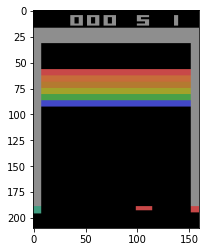

In [ ]:
render = True
n_episodes = 1

env.reset()
prev_screen = env.render(mode='rgb_array')
plt.imshow(prev_screen)

In [ ]:
env.close()

In order to test everything is setting, we run a random process on the environment.

In [ ]:
# https://github.com/nbgraham/RL-Race-Car-Simulator
render = True
n_episodes = 10

rewards = []
observation_list = []
render_list = []
for i_episode in range(n_episodes):
    observation = env.reset()
    sum_reward = 0
    t = 0
    while True:
        if render:
            render_list.append(env.render(mode='rgb_array'))

        action = env.action_space.sample()
        observation, reward, done, _ = env.step(action)
        observation_list.append(observation)

        # break
        sum_reward += reward
        
        t+=1
       
        if done:
            print("Episode {} finished after {} timesteps".format(i_episode, t+1))
            print("Reward: {}".format(sum_reward))
            rewards.append(sum_reward)
            break

Episode 0 finished after 802 timesteps
Reward: 2.0
Episode 1 finished after 796 timesteps
Reward: 2.0
Episode 2 finished after 995 timesteps
Reward: 3.0
Episode 3 finished after 500 timesteps
Reward: 0.0
Episode 4 finished after 1074 timesteps
Reward: 3.0
Episode 5 finished after 905 timesteps
Reward: 2.0
Episode 6 finished after 1098 timesteps
Reward: 3.0
Episode 7 finished after 612 timesteps
Reward: 1.0
Episode 8 finished after 496 timesteps
Reward: 0.0
Episode 9 finished after 618 timesteps
Reward: 1.0


Display the observation to see what happens in the game.

(210, 160, 3)


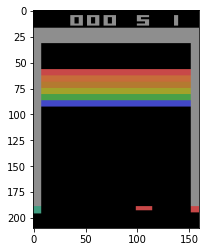

In [ ]:
plt.imshow(observation_list[0])
print(observation_list[0].shape)

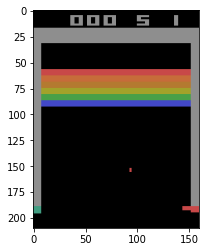

In [ ]:
plt.imshow(render_list[100])

## 2.Import necessary python files

The code of part 2 is copied and modified from the Openai gym official files.
- https://github.com/openai/gym/tree/master/gym/wrappers

The function of following code is to preprocess the environment, including clipping the reward to [-1,1], overwritting the step and reset function of the environment.

In [ ]:
class MaxAndSkipEnv(gym.Wrapper):
    def __init__(self, env, skip=4):
        """Return only every `skip`-th frame"""
        gym.Wrapper.__init__(self, env)
        # most recent raw observations (for max pooling across time steps)
        self._obs_buffer = np.zeros(
            (2,) + env.observation_space.shape, dtype=np.uint8)
        self._skip = skip

    def step(self, action):
        """Repeat action, sum reward, and max over last observations."""
        total_reward = 0.0
        done = None
        for i in range(self._skip):
            obs, reward, done, info = self.env.step(action)
            if i == self._skip - 2:
                self._obs_buffer[0] = obs
            if i == self._skip - 1:
                self._obs_buffer[1] = obs
            total_reward += reward
            if done:
                break
        # Note that the observation on the done=True frame
        # doesn't matter
        max_frame = self._obs_buffer.max(axis=0)

        return max_frame, total_reward, done, info

    def reset(self, **kwargs):
        return self.env.reset(**kwargs)


class ClipRewardEnv(gym.RewardWrapper):
    def __init__(self, env):
        gym.RewardWrapper.__init__(self, env)

    def reward(self, reward):
        """Bin reward to {+1, 0, -1} by its sign."""
        return np.sign(reward)


class FireResetEnv(gym.Wrapper):
    def __init__(self, env):
        """Take action on reset for environments that are fixed until firing."""
        gym.Wrapper.__init__(self, env)
        assert env.unwrapped.get_action_meanings()[1] == 'FIRE'
        assert len(env.unwrapped.get_action_meanings()) >= 3

    def reset(self, **kwargs):
        self.env.reset(**kwargs)
        obs, _, done, _ = self.env.step(1)
        if done:
            self.env.reset(**kwargs)
        obs, _, done, _ = self.env.step(2)
        if done:
            self.env.reset(**kwargs)
        return obs

    def step(self, ac):
        return self.env.step(ac)


class EpisodicLifeEnv(gym.Wrapper):
    def __init__(self, env):
        """Make end-of-life == end-of-episode, but only reset on true game over.
        Done by DeepMind for the DQN and co. since it helps value estimation.
        """
        gym.Wrapper.__init__(self, env)
        self.lives = 0
        self.was_real_done = True

    def step(self, action):
        obs, reward, done, info = self.env.step(action)
        self.was_real_done = done
        # check current lives, make loss of life terminal,
        # then update lives to handle bonus lives
        lives = self.env.unwrapped.ale.lives()
        if lives < self.lives and lives > 0:
            # for Qbert sometimes we stay in lives == 0 condition for a few frames
            # so it's important to keep lives > 0, so that we only reset once
            # the environment advertises done.
            done = True
        self.lives = lives
        return obs, reward, done, info

    def reset(self, **kwargs):
        """Reset only when lives are exhausted.
        This way all states are still reachable even though lives are episodic,
        and the learner need not know about any of this behind-the-scenes.
        """
        if self.was_real_done:
            obs = self.env.reset(**kwargs)
        else:
            # no-op step to advance from terminal/lost life state
            obs, _, _, _ = self.env.step(0)
        self.lives = self.env.unwrapped.ale.lives()
        return obs


# in torch imgs have shape [c, h, w] instead of common [h, w, c]
class AntiTorchWrapper(gym.ObservationWrapper):
    def __init__(self, env):
        gym.ObservationWrapper.__init__(self, env)

        self.img_size = [env.observation_space.shape[i]
                         for i in [1, 2, 0]
                         ]
        self.observation_space = gym.spaces.Box(0.0, 1.0, self.img_size)

    def observation(self, img):
        """what happens to each observation"""
        img = img.transpose(1, 2, 0)
        return img

The following code is copied from https://github.com/yandexdataschool/Practical_RL/blob/master/week04_approx_rl/framebuffer.py. The function of htis warpper is to concatenate four continuous frames.

In [ ]:
class FrameBuffer(Wrapper):
    def __init__(self, env, n_frames=4, dim_order='tensorflow'):
        """A gym wrapper that reshapes, crops and scales image into the desired shapes"""
        super(FrameBuffer, self).__init__(env)
        self.dim_order = dim_order
        if dim_order == 'tensorflow':
            height, width, n_channels = env.observation_space.shape
            obs_shape = [height, width, n_channels * n_frames]
        elif dim_order == 'pytorch':
            n_channels, height, width = env.observation_space.shape
            obs_shape = [n_channels * n_frames, height, width]
        else:
            raise ValueError(
                'dim_order should be "tensorflow" or "pytorch", got {}'.format(dim_order))
        self.observation_space = Box(0.0, 1.0, obs_shape)
        self.framebuffer = np.zeros(obs_shape, 'float32')

    def reset(self):
        """resets breakout, returns initial frames"""
        self.framebuffer = np.zeros_like(self.framebuffer)
        self.update_buffer(self.env.reset())
        return self.framebuffer

    def step(self, action):
        """plays breakout for 1 step, returns frame buffer"""
        new_img, reward, done, info = self.env.step(action)
        self.update_buffer(new_img)
        return self.framebuffer, reward, done, info

    def update_buffer(self, img):
        if self.dim_order == 'tensorflow':
            offset = self.env.observation_space.shape[-1]
            axis = -1
            cropped_framebuffer = self.framebuffer[:, :, :-offset]
        elif self.dim_order == 'pytorch':
            offset = self.env.observation_space.shape[0]
            axis = 0
            cropped_framebuffer = self.framebuffer[:-offset]
        self.framebuffer = np.concatenate(
            [img, cropped_framebuffer], axis=axis)

The following code is copied from https://github.com/yandexdataschool/Practical_RL/blob/master/week04_approx_rl/utils.py.

It convenient to use those helper function in the training process,like sum the discounted reward and record the training information.

In [ ]:
import psutil
from scipy.signal import fftconvolve, gaussian
import os

def get_cum_discounted_rewards(rewards, gamma):
    """
    evaluates cumulative discounted rewards:
    r_t + gamma * r_{t+1} + gamma^2 * r_{t_2} + ...
    """
    cum_rewards = []
    cum_rewards.append(rewards[-1])
    for r in reversed(rewards[:-1]):
        cum_rewards.insert(0, r + gamma * cum_rewards[0])
    return cum_rewards


def play_and_log_episode(env, agent, gamma=0.99, t_max=10000):
    """
    always greedy
    """
    states = []
    v_mc = []
    v_agent = []
    q_spreads = []
    td_errors = []
    rewards = []

    s = env.reset()
    for step in range(t_max):
        states.append(s)
        qvalues = agent.get_qvalues([s])
        max_q_value, min_q_value = np.max(qvalues), np.min(qvalues)
        v_agent.append(max_q_value)
        q_spreads.append(max_q_value - min_q_value)
        if step > 0:
            td_errors.append(
                np.abs(rewards[-1] + gamma * v_agent[-1] - v_agent[-2]))

        action = qvalues.argmax(axis=-1)[0]

        s, r, done, _ = env.step(action)
        rewards.append(r)
        if done:
            break
    td_errors.append(np.abs(rewards[-1] + gamma * v_agent[-1] - v_agent[-2]))

    v_mc = get_cum_discounted_rewards(rewards, gamma)

    return_pack = {
        'states': np.array(states),
        'v_mc': np.array(v_mc),
        'v_agent': np.array(v_agent),
        'q_spreads': np.array(q_spreads),
        'td_errors': np.array(td_errors),
        'rewards': np.array(rewards),
        'episode_finished': np.array(done)
    }

    return return_pack


def img_by_obs(obs, state_dim):
    """
    Unwraps obs by channels.
    observation is of shape [c, h=w, w=h]
    """
    return obs.reshape([-1, state_dim[2]])


def is_enough_ram(min_available_gb=0.1):
    mem = psutil.virtual_memory()
    return mem.available >= min_available_gb * (1024 ** 3)


def linear_decay(init_val, final_val, cur_step, total_steps):
    if cur_step >= total_steps:
        return final_val
    return (init_val * (total_steps - cur_step) +
            final_val * cur_step) / total_steps


def smoothen(values):
    kernel = gaussian(100, std=100)
    # kernel = np.concatenate([np.arange(100), np.arange(99, -1, -1)])
    kernel = kernel / np.sum(kernel)
    return fftconvolve(values, kernel, 'valid')

The following code is copied from the openai official github https://github.com/openai/baselines/blob/master/baselines/deepq/replay_buffer.py for creating reply buffer(experience repaly)

In [ ]:
class ReplayBuffer(object):
    def __init__(self, size):
        """Create Replay buffer.
        Parameters
        ----------
        size: int
            Max number of transitions to store in the buffer. When the buffer
            overflows the old memories are dropped.
        """
        self._storage = []
        self._maxsize = size
        self._next_idx = 0

    def __len__(self):
        return len(self._storage)

    def add(self, obs_t, action, reward, obs_tp1, done):
        data = (obs_t, action, reward, obs_tp1, done)

        if self._next_idx >= len(self._storage):
            self._storage.append(data)
        else:
            self._storage[self._next_idx] = data
        self._next_idx = (self._next_idx + 1) % self._maxsize

    def _encode_sample(self, idxes):
        obses_t, actions, rewards, obses_tp1, dones = [], [], [], [], []
        for i in idxes:
            data = self._storage[i]
            obs_t, action, reward, obs_tp1, done = data
            obses_t.append(np.array(obs_t, copy=False))
            actions.append(np.array(action, copy=False))
            rewards.append(reward)
            obses_tp1.append(np.array(obs_tp1, copy=False))
            dones.append(done)
        return (
            np.array(obses_t),
            np.array(actions),
            np.array(rewards),
            np.array(obses_tp1),
            np.array(dones)
        )

    def sample(self, batch_size):
        """Sample a batch of experiences.
        Parameters
        ----------
        batch_size: int
            How many transitions to sample.
        Returns
        -------
        obs_batch: np.array
            batch of observations
        act_batch: np.array
            batch of actions executed given obs_batch
        rew_batch: np.array
            rewards received as results of executing act_batch
        next_obs_batch: np.array
            next set of observations seen after executing act_batch
        done_mask: np.array
            done_mask[i] = 1 if executing act_batch[i] resulted in
            the end of an episode and 0 otherwise.
        """
        idxes = [
            random.randint(0, len(self._storage) - 1)
            for _ in range(batch_size)
        ]
        return self._encode_sample(idxes)

## 3.Process the environment

Crop the image to the size of 84* 84. Convert the RGB image to grayscale.

In [ ]:
class PreprocessAtariObs(ObservationWrapper):
    def __init__(self, env):
        """A gym wrapper that crops, scales image into the desired shapes and grayscales it."""
        ObservationWrapper.__init__(self, env)

        self.img_size = (1, 84, 84)
        self.observation_space = Box(0.0, 1.0, self.img_size)


    def _to_gray_scale(self, rgb, channel_weights=[0.8, 0.1, 0.1]):        
        pass


    def observation(self, img):
        """what happens to each observation"""

        # Here's what you need to do:
        #  * crop image, remove irrelevant parts
        #  * resize image to self.img_size
        #     (use imresize from any library you want,
        #      e.g. opencv, skimage, PIL, keras)
        #  * cast image to grayscale
        #  * convert image pixels to (0,1) range, float32 type
        
        img = img[30:-15, 8:-8, :]
        img = cv2.resize(img, (self.img_size[1], self.img_size[2]))
        img = img.mean(-1, keepdims=True)
        img = moveaxis(img, 2, 0)
        img = img.astype('float32') / 255.0

        return img

Here, processing step has finished. We create a new environment and test its the code!

Formal tests seem fine.


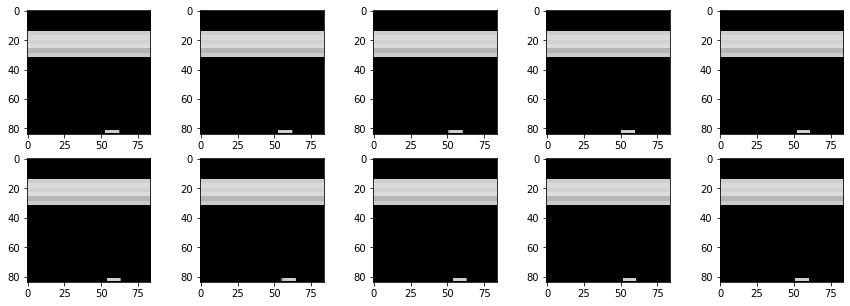

In [ ]:
# spawn game instance for tests
env = gym.make(ENV_NAME)  # create raw env
env = PreprocessAtariObs(env)
observation_shape = env.observation_space.shape
n_actions = env.action_space.n
env.reset()
obs, _, _, _ = env.step(env.action_space.sample())

# test observation
assert obs.ndim == 3, "observation must be [channel, h, w] even if there's just one channel"
assert obs.shape == observation_shape
assert obs.dtype == 'float32'
assert len(np.unique(obs)) > 2, "your image must not be binary"
assert 0 <= np.min(obs) and np.max(
    obs) <= 1, "convert image pixels to [0,1] range"

assert np.max(obs) >= 0.5, "It would be easier to see a brighter observation"
assert np.mean(obs) >= 0.1, "It would be easier to see a brighter observation"

print("Formal tests seem fine.")

n_cols = 5
n_rows = 2
fig = plt.figure(figsize=(15, 5))
obs = env.reset()
for row in range(n_rows):
    for col in range(n_cols):
        ax = fig.add_subplot(n_rows, n_cols, row * n_cols + col + 1)
        ax.imshow(obs[0, :, :], interpolation='none', cmap='gray')
        obs, _, _, _ = env.step(env.action_space.sample())
plt.show()

### Warpping

Create a function to process the environment in one step.

In [ ]:
def PrimaryAtariWrap(env, clip_rewards=True):
    assert 'NoFrameskip' in env.spec.id

    # This wrapper holds the same action for <skip> frames and outputs
    # the maximal pixel value of 2 last frames (to handle blinking
    # in some envs)
    env = MaxAndSkipEnv(env, skip=4)

    # This wrapper sends done=True when each life is lost
    # (not all the 5 lives that are givern by the game rules).
    # It should make easier for the agent to understand that losing is bad.
    env = EpisodicLifeEnv(env)

    # This wrapper laucnhes the ball when an episode starts.
    # Without it the agent has to learn this action, too.
    # Actually it can but learning would take longer.
    env = FireResetEnv(env)

    # This wrapper transforms rewards to {-1, 0, 1} according to their sign
    if clip_rewards:
        env = ClipRewardEnv(env)

    # This wrapper is yours :)
    env = PreprocessAtariObs(env)
    return env

### FrameBuffer

Use FrameBuffer to concatenate the 4 consecutive frames

In [ ]:
def make_env(clip_rewards=True, seed=None):
    env = gym.make(ENV_NAME)  # create raw env
    if seed is not None:
        env.seed(seed)
    env = PrimaryAtariWrap(env, clip_rewards)
    env = FrameBuffer(env, n_frames=4, dim_order='pytorch')
    return env

env = make_env()
env.reset()
n_actions = env.action_space.n
state_shape = env.observation_space.shape
print(n_actions)
print(state_shape)

4
(4, 84, 84)


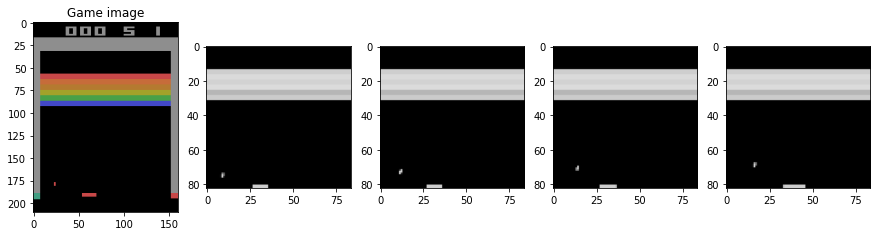

In [ ]:
for _ in range(12):
    obs, _, _, _ = env.step(env.action_space.sample())
    
plt.figure(figsize=[15,5])
plt.subplot(1,5,1)
plt.title("Game image")
plt.imshow(env.render("rgb_array"))
plt.subplot(1,5,2)
plt.imshow(img_by_obs(obs, state_shape)[0:83,:], cmap='gray')
plt.subplot(1,5,3)
plt.imshow(img_by_obs(obs, state_shape)[84:167,:], cmap='gray')
plt.subplot(1,5,4)
plt.imshow(img_by_obs(obs, state_shape)[168:251,:], cmap='gray')
plt.subplot(1,5,5)
plt.imshow(img_by_obs(obs, state_shape)[252:335,:], cmap='gray')
plt.show()

## 4.Build DQN Agent

Design a DQN agent with 3-hidden convolution layers, and use Relu as the activation function. The output layer is a dense layer with an action size output. It will decide the action according to a random choice or q values based on the epsilon(possibility value).

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

![image.png](attachment:image.png)

![image.png](attachment:image.png)

In [ ]:
class DQN_Agent(nn.Module):
    def __init__(self, epsilon=0):
        super().__init__()
        
        self.epsilon = epsilon
        self.n_actions = env.action_space.n
        self.obs_shape = env.observation_space.shape
        
        self.cnn = nn.Sequential(
            nn.Conv2d(self.obs_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Flatten()
        )
        with torch.no_grad():
            n_flatten = self.cnn(torch.zeros(env.observation_space.shape).unsqueeze(0)).shape[1]
            
        self.out = nn.Sequential(
            nn.Linear(n_flatten, 512),
            nn.ReLU(),
            nn.Linear(512, self.n_actions)
        )
        
    def forward(self, x):
        x = self.cnn(x)
        x = self.out(x)
        return x

    def get_qvalues(self, states):
        model_device = next(self.parameters()).device
        states = torch.tensor(states, device=model_device, dtype=torch.float)
        qvalues = self.forward(states)
        return qvalues.data.cpu().numpy()

    def sample_actions(self, qvalues):
        epsilon = self.epsilon
        batch_size, n_actions = qvalues.shape

        random_actions = np.random.choice(n_actions, size=batch_size)
        best_actions = qvalues.argmax(axis=-1)

        should_explore = np.random.choice([0, 1], batch_size, p=[1-epsilon, epsilon])
        return np.where(should_explore, random_actions, best_actions)

In [ ]:
a = torch.zeros((64,4,84,84))
test = DQN_Agent()
b = test(a)
print(b.shape)

torch.Size([64, 4])


In [ ]:
agent = DQN_Agent(epsilon=0.5).to(device)

### Debug the model

Test the agent to ensure the result is right!

In [ ]:
def evaluate(env, agent, n_games=1, greedy=False, t_max=10000):
    """ Plays n_games full games. If greedy, picks actions as argmax(qvalues). Returns mean reward. """
    rewards = []
    for _ in range(n_games):
        s = env.reset()
        reward = 0
        for _ in range(t_max):
            qvalues = agent.get_qvalues([s])
            action = qvalues.argmax(axis=-1)[0] if greedy else agent.sample_actions(qvalues)[0]
            s, r, done, _ = env.step(action)
            reward += r
            if done:
                break

        rewards.append(reward)
    return np.mean(rewards)

In [ ]:
evaluate(env, agent, n_games=1)

0.0

## 5.Define the Memory Buffer

Create the replay buffer and use the agent to play the game test the result.

In [ ]:
exp_replay = ReplayBuffer(10)

for _ in range(30):
    exp_replay.add(env.reset(), env.action_space.sample(),
                   1.0, env.reset(), done=False)

obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch = exp_replay.sample(
    5)

assert len(exp_replay) == 10, "experience replay size should be 10 because that's what maximum capacity is"

In [ ]:
def play_and_record(initial_state, agent, env, exp_replay, n_steps=1):
    """
    Play the game for exactly n steps, record every (s,a,r,s', done) to replay buffer. 
    Whenever game ends, add record with done=True and reset the game.
    It is guaranteed that env has done=False when passed to this function.

    PLEASE DO NOT RESET ENV UNLESS IT IS "DONE"

    :returns: return sum of rewards over time and the state in which the env stays
    """
    s = initial_state
    sum_rewards = 0

    # Play the game for n_steps as per instructions above
    for i in range(n_steps):
        
        qvalues = agent.get_qvalues([s])
        action = agent.sample_actions(qvalues)[0]
        next_s, r, done, _ = env.step(action)
        
        sum_rewards += r
        exp_replay.add(s, action, r, next_s, done)
        
        if done:
            s = env.reset()
        else:
            s = next_s

    return sum_rewards, s

## 6.Define Loss function

Define a Loss function to compute the loss value according the Q-learning function.

In [ ]:
def compute_loss(states, actions, rewards, next_states, is_done, eval_network, target_network, gamma=0.99, check_shapes=False, device=device):
    """ Compute td loss using torch operations only. Use the formulae above. """
    states = torch.tensor(states, device=device, dtype=torch.float)    # shape: [batch_size, *state_shape]

    # for some torch reason should not make actions a tensor
    actions = torch.tensor(actions, device=device, dtype=torch.long)    # shape: [batch_size]
    rewards = torch.tensor(rewards, device=device, dtype=torch.float)  # shape: [batch_size]
    # shape: [batch_size, *state_shape]
    next_states = torch.tensor(next_states, device=device, dtype=torch.float)
    is_done = torch.tensor(
        is_done.astype('float32'),
        device=device,
        dtype=torch.float
    )  # shape: [batch_size]
    is_not_done = 1 - is_done

    # get q-values for all actions in current states
    predicted_qvalues = eval_network(states)

    # compute q-values for all actions in next states
    predicted_next_qvalues = target_network(next_states)
    
    # select q-values for chosen actions
    predicted_qvalues_for_actions = predicted_qvalues[range(
        len(actions)), actions]

    # compute V*(next_states) using predicted next q-values
    next_state_values, _ = torch.max(predicted_next_qvalues, 1)

    assert next_state_values.dim(
    ) == 1 and next_state_values.shape[0] == states.shape[0], "must predict one value per state"

    # compute "target q-values" for loss - it's what's inside square parentheses in the above formula.
    # at the last state use the simplified formula: Q(s,a) = r(s,a) since s' doesn't exist
    # you can multiply next state values by is_not_done to achieve this.
    target_qvalues_for_actions = rewards + (gamma * next_state_values * is_not_done)

    # mean squared error loss to minimize
    loss = torch.mean((predicted_qvalues_for_actions -
                       target_qvalues_for_actions.detach()) ** 2)

    if check_shapes:
        assert predicted_next_qvalues.data.dim(
        ) == 2, "make sure you predicted q-values for all actions in next state"
        assert next_state_values.data.dim(
        ) == 1, "make sure you computed V(s') as maximum over just the actions axis and not all axes"
        assert target_qvalues_for_actions.data.dim(
        ) == 1, "there's something wrong with target q-values, they must be a vector"

    return loss

## 7. Training

Set fixed random seed.

In [ ]:
seed = 4
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

Set Hyperparameters.

![image.png](attachment:image.png)

As the training really takes time, we set checkpints and store the model in to lots of checkpints and when we reconnect to train, we can use the torch.load function to continuet he training process.

In [ ]:
STEP_PER_EPOCH = 1
BATCH_SIZE = 32
TOTAL_STEP = int(3e6)
DECAY_SLOPE = int(1e6)
INIT_EPSILON = 1
FINAL_EPSILON = 0.1
LOSS_FREQUENCY = 50
TARGET_UPDATE = 5000
EVAL_FREQUENCY = 5000
max_grad_norm = 50
n_lives = 5

SAVE_PATH = "/scratch/hp2173/AttentionDQN/DQN_Breakout/"
LOAD_PATH = "/scratch/hp2173/AttentionDQN/DQN_Breakout/"
SAVE_INTERVAL = 10000

LOG_DIR = "/scratch/hp2173/AttentionDQN/DQN_Breakout_log/"
summary_writer = SummaryWriter(LOG_DIR)

Create the eval net and the target net.

In [ ]:
env = make_env(seed)
state_shape = env.observation_space.shape
n_actions = env.action_space.n
state = env.reset()

agent = DQN_Agent(epsilon=1).to(device)
target_network = DQN_Agent().to(device)
target_network.load_state_dict(agent.state_dict())
optimizer = torch.optim.Adam(agent.parameters(), lr=1e-4)

Create a repaly buffer with the size of the 1e5

In [ ]:
exp_replay = ReplayBuffer(int(1e5))

In [ ]:
mean_rw_history = []
loss_history = []
grad_norm_history = []
initial_state_q_history = []
step = 0

Start to train and store the result in the tensorboard writter.

buffer size = 100000, epsilon = 0.10000


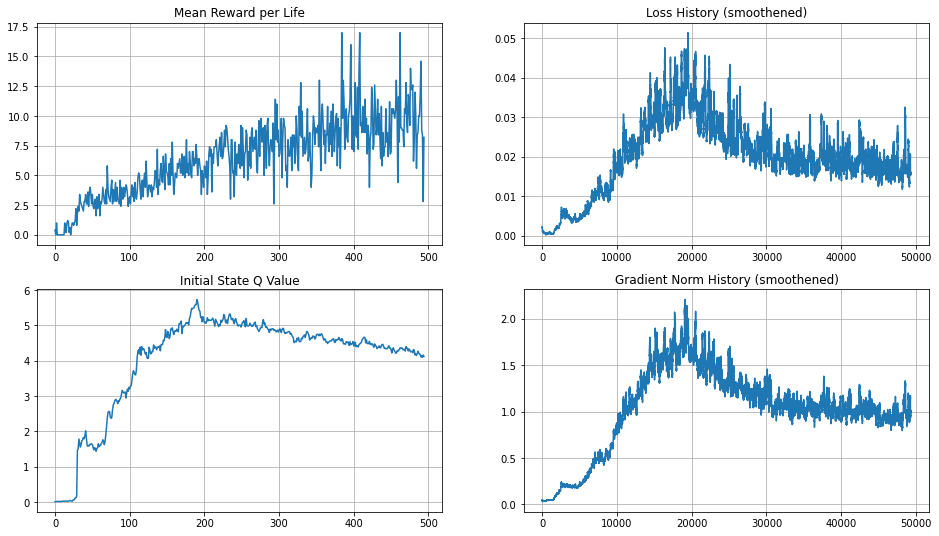

 82%|████████▏ | 2475000/3000001 [10:57:09<2:19:23, 62.77it/s]  


KeyboardInterrupt: 

In [ ]:
state = env.reset()
for step in trange(step, TOTAL_STEP + 1):

    agent.epsilon = linear_decay(INIT_EPSILON, FINAL_EPSILON, step, DECAY_SLOPE)

    # play
    _, state = play_and_record(state, agent, env, exp_replay, STEP_PER_EPOCH)

    # train
    obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch = exp_replay.sample(BATCH_SIZE)

    loss = compute_loss(obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch, agent, target_network, gamma=0.99, check_shapes=True)

    loss.backward()
    grad_norm = nn.utils.clip_grad_norm_(agent.parameters(), max_grad_norm)
    optimizer.step()
    optimizer.zero_grad()

    if step % LOSS_FREQUENCY == 0:
        loss_hist = loss.data.cpu().item()
        loss_history.append(loss_hist)
        summary_writer.add_scalar('Loss History', loss_hist, global_step=step)
        grad_norm_history.append(grad_norm)
        summary_writer.add_scalar('Gradient Norm', grad_norm, global_step=step)

    if step % TARGET_UPDATE == 0:
        # Load agent weights into target_network
        target_network.load_state_dict(agent.state_dict())

    if step % EVAL_FREQUENCY == 0:
        mean_rw = evaluate(make_env(clip_rewards=True, seed=step), agent, n_games=3 * n_lives, greedy=True)
        mean_rw_history.append(mean_rw)
        summary_writer.add_scalar('Mean Reward per life', mean_rw, global_step=step)
        
        initial_state_q_values = np.max(agent.get_qvalues([make_env(seed=step).reset()]))
        initial_state_q_history.append(initial_state_q_values)
        summary_writer.add_scalar('Initial state Q values', initial_state_q_values, global_step=step)
        
    if step % SAVE_INTERVAL == 0:
        if os.path.isdir(SAVE_PATH):
            torch.save(agent.state_dict(),SAVE_PATH + 'DQN_Breakout{}.pth'.format(step))
        else:
            os.makedirs(SAVE_PATH, exist_ok=True)
            torch.save(agent.state_dict(),SAVE_PATH + 'DQN_Breakout{}.pth'.format(step))
        print('Checkpoint {} saved to {}'.format(step, SAVE_PATH + 'DQN_Breakout{}.pth'.format(step))) 
        

        clear_output(True)
        print("buffer size = %i, epsilon = %.5f" %
              (len(exp_replay), agent.epsilon))

        plt.figure(figsize=[16, 9])

        plt.subplot(2, 2, 1)
        plt.title("Mean Reward per Life")
        plt.plot(mean_rw_history)
        plt.grid()

        assert not np.isnan(loss_history[-1])
        plt.subplot(2, 2, 2)
        plt.title("Loss History (smoothened)")
        plt.plot(smoothen(loss_history))
        plt.grid()

        plt.subplot(2, 2, 3)
        plt.title("Initial State Q Value")
        plt.plot(initial_state_q_history)
        plt.grid()

        plt.subplot(2, 2, 4)
        plt.title("Gradient Norm History (smoothened)")
        plt.plot(smoothen(grad_norm_history))
        plt.grid()

        plt.show()

## 8.Evaluation

In [ ]:
agent.load_state_dict(torch.load(LOAD_PATH + 'DQN_Breakout{}.pth'.format(epoch)))

Running 30 times and test the final score.

In [ ]:
final_score = evaluate(
  make_env(clip_rewards=False, seed=9),
    agent, n_games=30, greedy=True, t_max=10 * 1000
) * n_lives
print('final score:', final_score)

final score: 140.0
